In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xtrack as xt
import xcoll as xc
import xpart as xp
import xobjects as xo

In [2]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

# Single turn tracking and one-turn-ebe recording

In [96]:
num_particles = 10000
num_turns = 5
plane = 'H'
amplitude_adt = 0.07
start_at_turn=1000
nemitt_x = 2e-6
nemitt_y = 2e-6

In [97]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

env = line.env
#crab cavities: acfcah.61738 and acfcah.61739
crab1 = xt.CrabCavity(crab_voltage=1e6, frequency = line['actcse.31632'].frequency, lag=0)
crab2 = xt.CrabCavity(crab_voltage=1e6, frequency = line['actcse.31632'].frequency, lag=0)
env.elements['acfcah.61738'] = crab1
env.elements['acfcah.61739'] = crab2
tt = line.get_table()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tidp = install_tidp(line, block_mvt=29e-3)
tcsm = install_tcsm(line)

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/32250 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32250 [00:00<?, ?it/s]

In [98]:
tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [99]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2333663781336932m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961264
--> Emittance: 0.34350824485557363


In [100]:
part_init = part.copy()

In [101]:
line.scattering.enable()
line.track(part, turn_by_turn_monitor='ONE_TURN_EBE')
line.scattering.disable()

In [102]:
res = line.record_last_track

In [103]:
mask_dead = part.state <= 0

In [104]:
idxs = part.particle_id[mask_dead]

In [105]:
res.x[mask_dead]

array([[ 0.01641793,  0.01641793,  0.01641793, ...,  0.01468852,
         0.01468852,  0.01468852],
       [ 0.01843397,  0.01843397,  0.01843397, ...,  0.01701503,
         0.01701503,  0.01701503],
       [ 0.00766005,  0.00766005,  0.00766005, ...,  0.00695643,
         0.00695643,  0.00695643],
       ...,
       [ 0.01520492,  0.01520492,  0.01520492, ...,  0.01397675,
         0.01397675,  0.01397675],
       [-0.00885948, -0.00885948, -0.00885948, ..., -0.01118858,
        -0.01118858, -0.01118858],
       [-0.00876414, -0.00876414, -0.00876414, ..., -0.00894461,
        -0.00894461, -0.00894461]], shape=(115, 32251))

In [106]:
part.at_element[mask_dead]

array([25260, 24693, 24442, 24418, 24394, 24394, 24388, 24388, 24388,
       24388, 24388, 24388, 24388, 24388, 24388, 24388, 24370, 24355,
       24339, 24339, 24339, 24339, 24331, 24331, 24331, 24331, 24331,
       24331, 24331, 24323, 24323, 24323, 24323, 24311, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306, 24306,
       24306, 24306, 24306, 24306, 24306, 24306, 24306])

In [107]:
line.element_names[24306]

np.str_('tcsm.51932')

In [108]:
res.x[mask_dead][-1, :24308]

array([-0.00876414, -0.00876414, -0.00876414, ...,  0.00326814,
        0.00326814,  0.0034141 ], shape=(24308,))

In [109]:
res.x[idxs]

array([[-0.00277914, -0.00277914, -0.00277914, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01092844, -0.01092844, -0.01092844, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02448482, -0.02448482, -0.02448482, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01230285,  0.01230285,  0.01230285, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00890195,  0.00890195,  0.00890195, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01079577, -0.01079577, -0.01079577, ...,  0.        ,
         0.        ,  0.        ]], shape=(115, 32251))

# Dead particles initial distribution

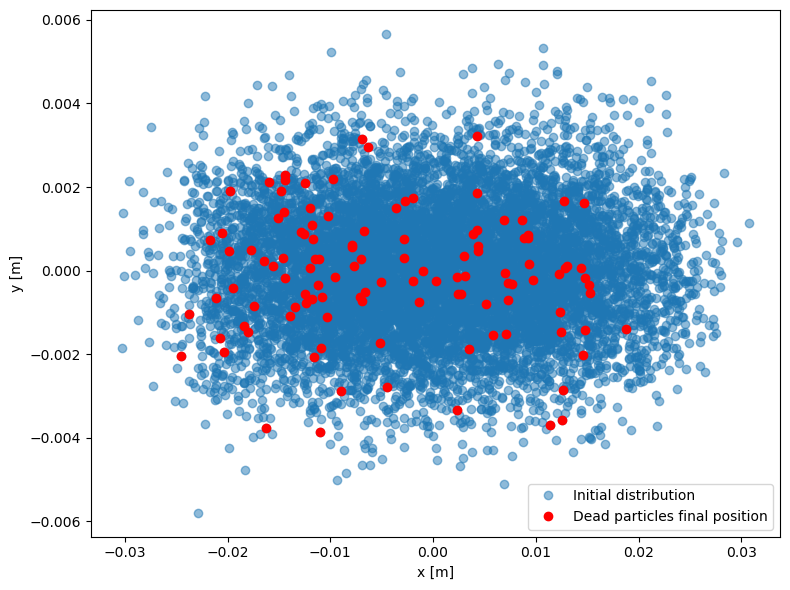

In [110]:
fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True)

ax.plot(part_init.x, part_init.y, 'o', label='Initial distribution', alpha=0.5)
ax.plot(part_init.x[idxs], part_init.y[idxs], 'o', label='Dead particles final position', color='red')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend()
fig.tight_layout()

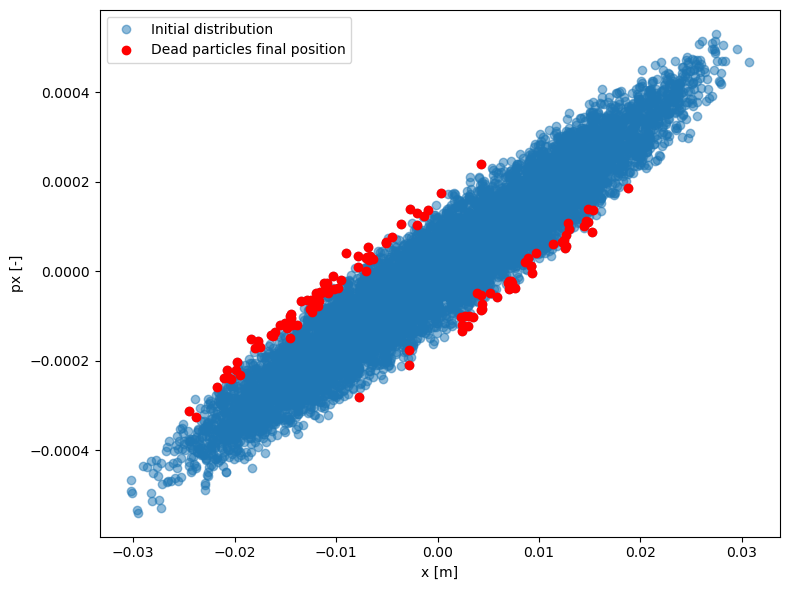

In [129]:
fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True)

ax.plot(part_init.x, part_init.px, 'o', label='Initial distribution', alpha=0.5)
ax.plot(part_init.x[idxs], part_init.px[idxs], 'o', label='Dead particles final position', color='red')
ax.set_xlabel('x [m]')
ax.set_ylabel('px [-]')
ax.legend()
fig.tight_layout()
plt.savefig('x_px_scatter_dead_particles.png', dpi=300)

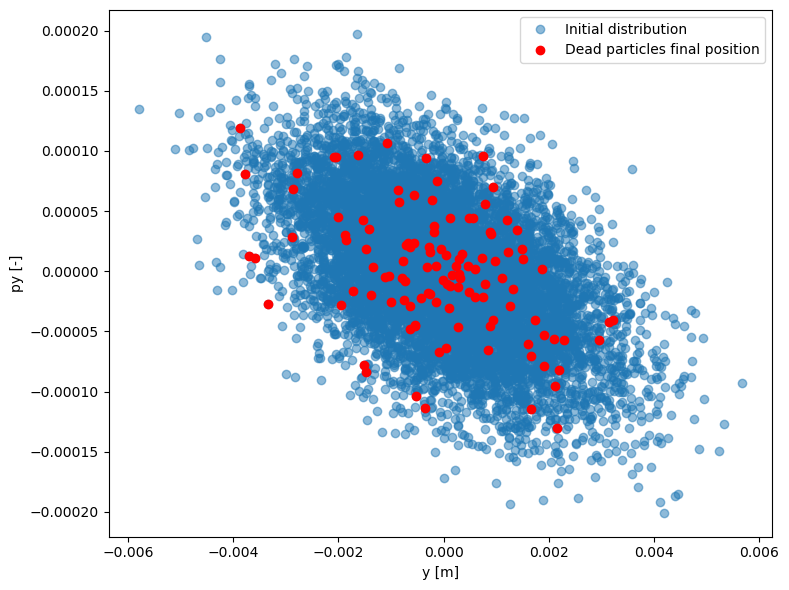

In [112]:
fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True)

ax.plot(part_init.y, part_init.py, 'o', label='Initial distribution', alpha=0.5)
ax.plot(part_init.y[idxs], part_init.py[idxs], 'o', label='Dead particles final position', color='red')
ax.set_xlabel('y [m]')
ax.set_ylabel('py [-]')
ax.legend()
fig.tight_layout()

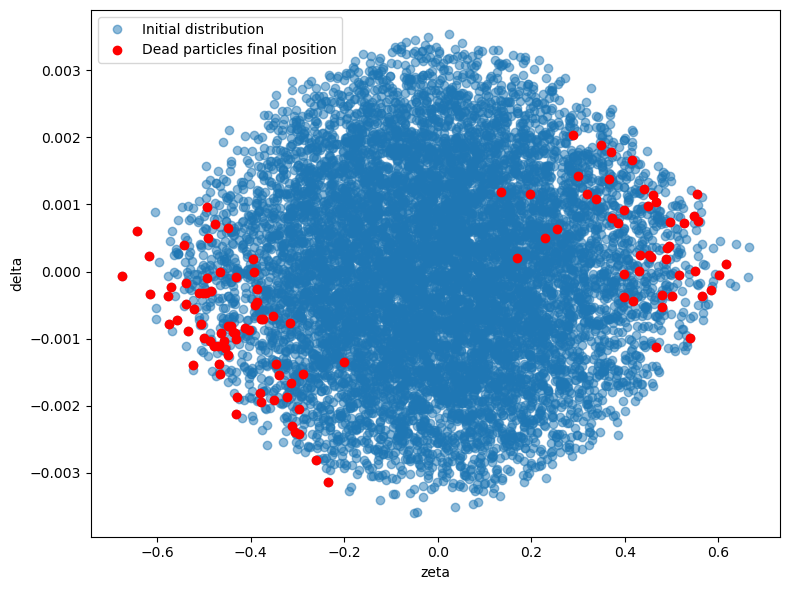

In [130]:
fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True)

ax.plot(part_init.zeta, part_init.delta, 'o', label='Initial distribution', alpha=0.5)
ax.plot(part_init.zeta[idxs], part_init.delta[idxs], 'o', label='Dead particles final position', color='red')
ax.set_xlabel('zeta')
ax.set_ylabel('delta')
ax.legend()
fig.tight_layout()
plt.savefig('zeta_delta_scatter_dead_particles.png', dpi=300)

# Trajectories in X and Y

In [114]:
import apertls

In [115]:
ap_calc = apertls.ApertureCalculator(line)
x_ext = ap_calc.compute_x_extent()
y_ext = ap_calc.compute_y_extent()

In [116]:
tt = line.get_table()
mask = [el.startswith('Limit') for el in tt.element_type]

In [117]:
int(np.trim_zeros(res.at_element[idxs][0])[-1])

25260

In [125]:
line['tcsm.51932'].jaw_R

np.float64(-0.007896699893982895)

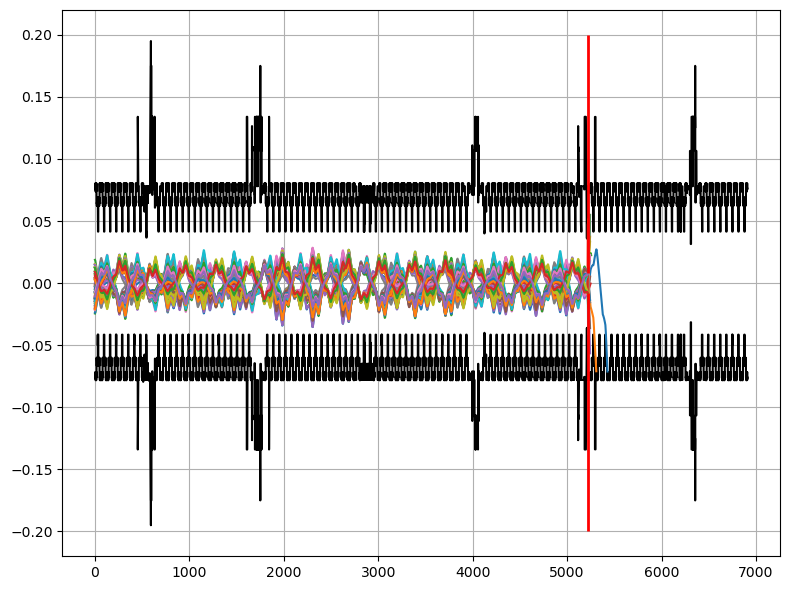

In [131]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(tt.s[mask], x_ext[:,0], color='k')
ax.plot(tt.s[mask], x_ext[:,1], color='k')
for idx in idxs:
    last_elem = int(np.trim_zeros(res.at_element[idx])[-1])
    ax.plot(res.s[idx][:last_elem-1], res.x[idx][:last_elem-1])

ax.vlines(line.get_s_position('tcsm.51932'), -0.2, line['tcsm.51932'].jaw_R, color='r', lw=2)
ax.vlines(line.get_s_position('tcsm.51932'), line['tcsm.51932'].jaw_L, 0.2, color='r', lw=2)
ax.grid()
fig.tight_layout()
plt.savefig('x_extent_with_dead_particles.png', dpi=300)

In [122]:
last_elems = []
for idx in idxs:
    last_elem = int(np.trim_zeros(res.at_element[idx])[-1])
    last_elems.append(last_elem)

last_elems = np.array(last_elems)
print(np.unique(last_elems, return_counts=True))

(array([24306, 24311, 24323, 24331, 24339, 24355, 24370, 24388, 24394,
       24418, 24442, 24693, 25260]), array([81,  1,  4,  7,  4,  1,  1, 10,  2,  1,  1,  1,  1]))


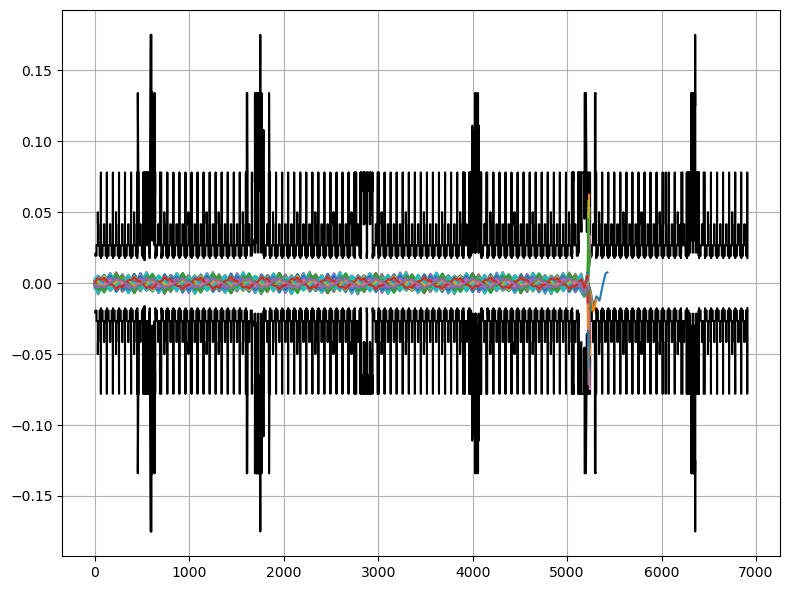

In [132]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(tt.s[mask], y_ext[:,0], color='k')
ax.plot(tt.s[mask], y_ext[:,1], color='k')
for idx in idxs:
    last_elem = int(np.trim_zeros(res.at_element[idx])[-1])
    ax.plot(res.s[idx][:last_elem-1], res.y[idx][:last_elem-1])

# ax.vlines(line.get_s_position('tcsm.51932'), -0.15, 0.15, color='r', ls='--')
ax.grid()
fig.tight_layout()
plt.savefig('y_extent_with_dead_particles.png', dpi=300)

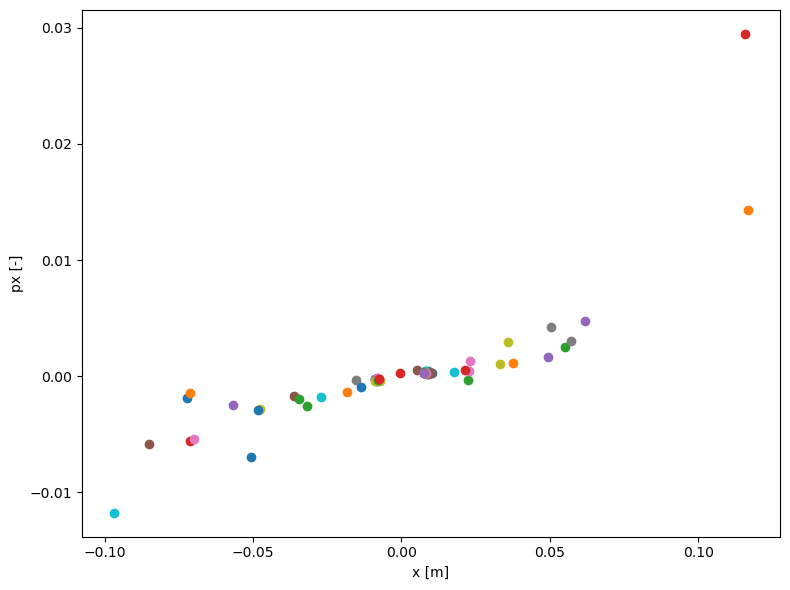

In [121]:
fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True)

for idx in idxs:
    last_elem = int(np.trim_zeros(res.at_element[idx])[-1])
    ax.scatter(res.x[idx][last_elem], res.px[idx][last_elem])
ax.set_xlabel('x [m]')
ax.set_ylabel('px [-]')
fig.tight_layout()